In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
!pip install -q cltk==0.1.121
!pip install -q nltk==3.5

In [ ]:
from cltk.corpus.utils.importer import CorpusImporter
my_latin_downloader = CorpusImporter('latin')
my_latin_downloader.import_corpus('latin_models_cltk')

INFO:CLTK:`~/cltk_data/distributed_corpora.yaml` file not found.
INFO:CLTK:No user-defined corpora found for "latin" language
INFO:CLTK:Cloning 'latin_models_cltk' from 'https://github.com/cltk/latin_models_cltk.git'


## Dataset

Latin texts ~~scraped from http://www.thelatinlibrary.com~~ downloaded from http://www.perseus.tufts.edu/hopper/


In [ ]:
!pip install -q gdown
![ -e works ] || gdown https://drive.google.com/uc?id=1eF5PoWA96d8eDrkcqli2Qsi_jjeHmVxW -O - | tar zxf -

Downloading...
From: https://drive.google.com/uc?id=1eF5PoWA96d8eDrkcqli2Qsi_jjeHmVxW
To: <_io.BufferedWriter name='<stdout>'>
100% 14.7M/14.7M [00:00<00:00, 15.4MB/s]


In [ ]:
import os

works_by_author = {}
for root, _, works in os.walk('works'):
    if len(works) == 0: continue
    _, author = root.split('/')
    works_by_author[author] = []

    for work in works:
        with open(f'{root}/{work}', 'r') as file:
            works_by_author[author].append(file.read())

In [ ]:
data_labels = []
data_train_x, data_train_y = [], []
data_test_x, data_test_y = [], []

for i, (author, works) in enumerate(works_by_author.items()):
    data_labels.append(author)
    for j, work in enumerate(works):
        if j < 0.5 * len(works):
            data_train_x.append(work)
            data_train_y.append(i)
        else:
            data_test_x.append(work)
            data_test_y.append(i)

data_train_y = np.array(data_train_y)
data_test_y = np.array(data_test_y)

In [ ]:
pd.DataFrame(data_labels)

,0
0,"Minucius Felix, Marcus"
1,Lucretius
2,Sidonius Apollinaris
3,Lucius Annaeus Florus
4,Prudentius
5,"Statius, P. Papinius"
6,Apuleius
7,P. Vergilius Maro
8,"Jerome, Saint"
9,Juvenal


In [ ]:
data_train_x[0][:200]

'\n\n\n\n\nPostquam castra duces, pugnae iam mente propinqui,\nImposuere iugis, admotaque cominus arma,\nParque suum videri dei, capere omnia Caesar\nMoenia Graiorum spernit, Martemque secundum\nIam nisi de gen'

In [ ]:
from cltk.tokenize.word import WordTokenizer
from cltk.stem.lemma import LemmaReplacer

word_tokenizer = WordTokenizer('latin')
lemmatizer = LemmaReplacer('latin')

## Naïve implementation

In [ ]:
#create a dict for each text
#create a dict of all the words that appear
#iterate over them and create dicts with probabilites for each word
#for now we removed the second allemanus

In [ ]:
from cltk.lemmatize.latin.backoff import BackoffLatinLemmatizer
from cltk.tokenize.word import WordTokenizer
from collections import defaultdict

class NaiveBayesWithCLTK:
    def __init__(self):
        self.lemmatizer = BackoffLatinLemmatizer('latin')
        self.tokenizer = WordTokenizer('latin')

    def split_words(self, text):
        tokens = self.tokenizer.tokenize(text)
        lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        return lemmatized_tokens
        import re
        return re.findall(r'(?u)\b\w\w+\b', text)

    def fit(self, x, y):
        workcount = defaultdict(int)
        wordcount = defaultdict(int)



        total_works = 0
        total_words = defaultdict(int)

        for work, author in zip(x, y):
            workcount[author] += 1
            total_works += 1
            for word in self.split_words(work):
                wordcount[author, tuple(word)] += 1
                total_words[author] += 1

        self.proba_word = {}
        self.proba_author = {}

        for author in workcount:
            self.proba_author[author] = workcount[author] / total_works

        for author, word in tqdm(wordcount):
            self.proba_word[author, tuple(word)] = wordcount[author, tuple(word)] / total_words[author]

        return self

    def predict(self, work):
        authors = list(self.proba_author.keys())
        likelihood = np.log([self.proba_author[a] for a in authors])
        for word in self.split_words(work):
            for i, a in enumerate(authors):
                proba = self.proba_word[a, tuple(word)] if (a, tuple(word)) in self.proba_word else 0.0
                likelihood[i] += np.log(proba + 1e-5)
        #return { author: likelihood[i] for i, author in enumerate(authors) }
        return authors[np.argmax(likelihood)]

model = NaiveBayesWithCLTK().fit(data_train_x, data_train_y)

sample_idx = np.random.choice(len(data_test_y), 300)
sample_idx = np.arange(len(data_test_y))
predicted = np.zeros(data_test_y.shape, dtype = int)
for i in tqdm(sample_idx):
    predicted[i] = model.predict(data_test_x[i])

(predicted[sample_idx] == data_test_y[sample_idx]).mean()


  0%|          | 0/572161 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

0.8916201117318435

In [ ]:
from collections import defaultdict

class NaiveBayes:
    def split_words(self, text):

        import re
        return re.findall(r'(?u)\b\w\w+\b', text)

    def fit(self, x, y):
        workcount = defaultdict(int)
        wordcount = defaultdict(int)

        total_works = 0
        total_words = defaultdict(int)

        for work, author in zip(x, y):
            workcount[author] += 1
            total_works += 1
            for word in self.split_words(work):
                wordcount[author, word] += 1
                total_words[author] += 1

        self.proba_word = {}
        self.proba_author = {}

        for author in workcount:
            self.proba_author[author] = workcount[author] / total_works

        for author, word in tqdm(wordcount):
            self.proba_word[author, word] = wordcount[author, word] / total_words[author]

        return self

    def predict(self, work):
        authors = list(self.proba_author.keys())
        likelihood = np.log([self.proba_author[a] for a in authors])
        for word in self.split_words(work):
            for i, a in enumerate(authors):
                proba = self.proba_word[a, word] if (a, word) in self.proba_word else 0.0
                likelihood[i] += np.log(proba + 1e-5)
        #return { author: likelihood[i] for i, author in enumerate(authors) }
        return authors[np.argmax(likelihood)]

model = NaiveBayes().fit(data_train_x, data_train_y)

sample_idx = np.random.choice(len(data_test_y), 300)
sample_idx = np.arange(len(data_test_y))
predicted = np.zeros(data_test_y.shape, dtype = int)
for i in tqdm(sample_idx):
    predicted[i] = model.predict(data_test_x[i])

(predicted[sample_idx] == data_test_y[sample_idx]).mean()

  0%|          | 0/667171 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

0.7319148936170212

## Using `sklearn`

Adapted from https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(data_train_x)

tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [ ]:
mnb = MultinomialNB(alpha=1e-3).fit(x_train_tfidf, data_train_y)

x_test_counts = count_vect.transform(data_test_x)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

predicted = mnb.predict(x_test_tfidf)
(data_test_y == predicted).mean()

0.8592178770949721

In [ ]:
cnb = ComplementNB(alpha=1e-2).fit(x_train_tfidf, data_train_y)

x_test_counts = count_vect.transform(data_test_x)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

predicted = cnb.predict(x_test_tfidf)
(data_test_y == predicted).mean()

0.8681564245810056

## K nearest neighbors?

  0%|          | 0/19 [00:00<?, ?it/s]

k=1, 0.4085106382978723
k=2, 0.4056737588652482
k=3, 0.6170212765957447
k=4, 0.5886524822695035
k=5, 0.5957446808510638
k=6, 0.5758865248226951
k=7, 0.5702127659574469
k=8, 0.5446808510638298
k=9, 0.5432624113475177
k=10, 0.5333333333333333
k=11, 0.526241134751773
k=12, 0.5092198581560283
k=13, 0.49645390070921985
k=14, 0.48936170212765956
k=15, 0.47801418439716314
k=16, 0.46808510638297873
k=17, 0.4652482269503546
k=18, 0.45673758865248226
k=19, 0.44964539007092197


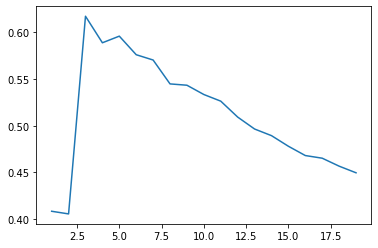

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.arange(1, 20)
accuracy = np.zeros(len(n_neighbors))

for i, k  in enumerate(tqdm(n_neighbors)):
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors=k)),
    ])

    text_clf.fit(data_train_x, data_train_y)

    predicted = text_clf.predict(data_test_x)
    accuracy[i] = np.mean(predicted == data_test_y)
    print(f"k={k}, {accuracy[i]}")

plt.plot(n_neighbors, accuracy)

### Support vector machines? (winner)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf.fit(data_train_x, data_train_y)

predicted = text_clf.predict(data_test_x)
np.mean(predicted == data_test_y)

0.9035460992907801

## Previous implementation on smaller dataset

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from urllib.request import urlopen
from bs4 import BeautifulSoup

import re

re_author = re.compile(r"transl\.\s*([^\n.]+)\.?\n", re.S)
re_meta = re.compile(r"\[[^]]*\]", re.S)
re_space = re.compile(r"\s+", re.S)

def fetch_fulltext(id):
    html = urlopen(f"https://dare.uni-koeln.de/app/fulltexts/{id}/raw")
    soup = BeautifulSoup(html, features="html.parser")

    contents = soup.find("div").get_text()
    m = re.search(re_author, contents)
    author = m.group(1)
    text = contents[m.end():]
    text = re.sub(re_meta, "", text)
    text = re.sub(re_space, " ", text)

    return author, text

ids_train = "FT1 FT19 FT9".split(" ")
ids_test = "FT3 FT4 FT5 FT13 FT6 FT2 FT7".split(" ")

data_train = [fetch_fulltext(id) for id in ids_train]
data_test = [fetch_fulltext(id) for id in ids_test]

In [ ]:
bigdict={}
import numpy as np


def count_words(dataset,samples):
 dicts=[{} for i in range (samples)]
 wordcount=np.zeros(samples)
 for i in range(0,samples):
   for word in dataset[i][1].split(' '):
     wordcount[i]+=1
     if not (word in dicts[i]):
       dicts[i][word]=1
     else:
       dicts[i][word]=dicts[i][word]+1
     bigdict[word]=1
   #print(word)
 return dicts,wordcount



def calc_prob(dicts,wordcount,samples):
 pdicts=[{} for i in range (samples)]
 for word in bigdict:
   for i in range(0,3):
     dim=len(dicts[i])
     if word in dicts[i]:
       pdicts[i][word]=(dicts[i][word]+1)/(wordcount[i]+dim)
     else:
       pdicts[i][word]=1/(wordcount[i]+dim)
 return pdicts


dtrain,wtrain=count_words(data_train,3)
pd=calc_prob(dtrain,wtrain,3)
dct,wcount=count_words(data_test,7)

for i in range(0,7):
 likelihood=np.log([0.3,0.3,0.3])
 for n in range(0,3):
   for word in dct[i]:
     if word in pd[n]:
       likelihood[n]=likelihood[n]+dct[i][word]*np.log(pd[n][word])
 likelihood=(-1)*likelihood
 for i in range(0,3):
   print(likelihood[i])
 if np.min(likelihood)==likelihood[0]:
   print("Hermannus Alemannus")
 elif np.min(likelihood)==likelihood[1]:
   print("Michael Scotus")
 elif np.min(likelihood)==likelihood[2]:
   print("William of Luna")

for i in range(0,3):
 likelihood=np.log([0.3,0.3,0.3])
 for n in range(0,3):
   for word in dtrain[i]:
     if word in pd[n]:
       likelihood[n]=likelihood[n]+dtrain[i][word]*np.log(pd[n][word])
 likelihood=(-1)*likelihood
 #for i in range(0,3):
  # print(likelihood[i])
 if np.min(likelihood)==likelihood[0]:
   print("Hermannus Alemannus")
 elif np.min(likelihood)==likelihood[1]:
   print("Michael Scotus")
 elif np.min(likelihood)==likelihood[2]:
   print("William of Luna")
#print(pdicts[0])

93144.3534100096
95538.13895817191
85930.41659414594
William of Luna
326172.7571076292
324206.8034505372
309599.09478745156
William of Luna
201268.7903368319
203641.21436027164
191748.7130778457
William of Luna
2661333.3347563855
2521183.9717865707
2558801.501485727
Michael Scotus
798728.4816572615
764526.6076104628
776112.9154639901
Michael Scotus
48981.16084815171
46042.01451615362
46938.33995817881
Michael Scotus
147007.3062899754
138969.61230364462
141714.76032653448
Michael Scotus
Hermannus Alemannus
Michael Scotus
William of Luna
